In [204]:
import numpy as np
from matplotlib import pyplot as plt
print("test")

test


In [205]:
## Currently assuming raw data is scalarFirst, and Crystal2Lab. (check this on Dryad) ##

# EBSD data is in Crystal2Lab, i.e. it brings a vector in the crystal frame to the lab frame. 
# The quaternion q is physical orientation of lab cube wrt crystal cube.

##

In [206]:
# Elements of symmetry groups are set transformations that leave an object invariant. \
# Symmetry groups are quaternion representations of point groups
# There are (naturally in 3D), 32 crystollographic point groups
# Our EBSD Nickel data exhibits Oh (m3m) cyrstallographic point group symmetry.
from orix.quaternion.symmetry import Oh

In [207]:
# Load and x-plane cross-section of a 3D EBSD microscope scan of Nickel unit crystal orientations 
all_data = np.load("Open_718_Test_hr_x_block_15.npy")

# all_data = np.roll(all_data, shift=1, axis=-1)
# data = np.roll(data, shift=1, axis=-1)

print(all_data[0][0])
print(all_data[0][1])
# Decrease computational burden for this excercise
data = all_data[200:240, 200:240]


[ 0.14931776 -0.13210519 -0.09392157  0.9754133 ]
[ 0.14931776 -0.13210519 -0.09392157  0.9754133 ]


In [208]:
from orix import plot
# plot.IPFColorKeyTSL(Oh).plot()

In [209]:
### import orix a PyPi library used for handling crystal orientation mapping data
from orix.quaternion import Orientation, OrientationRegion, Rotation, Quaternion

# Elements of symmetry groups are set transformations that leave an object invariant. \
# Symmetry groups are quaternion representations of point groups
# There are (naturally in 3D), 32 crystollographic point groups
# Our EBSD Nickel data exhibits Oh (m3m) cyrstallographic point group symmetry.
from orix.quaternion.symmetry import Oh

In [210]:
# Convert numpy quaternion data to orix Orientations
ori_all = Orientation(all_data)

ori = Orientation(data)
shape = ori.shape

ori = ori.flatten()
ori.symmetry = Oh
# ori = ori.map_into_symmetry_reduced_zone()
print(ori.shape)

(1600,)


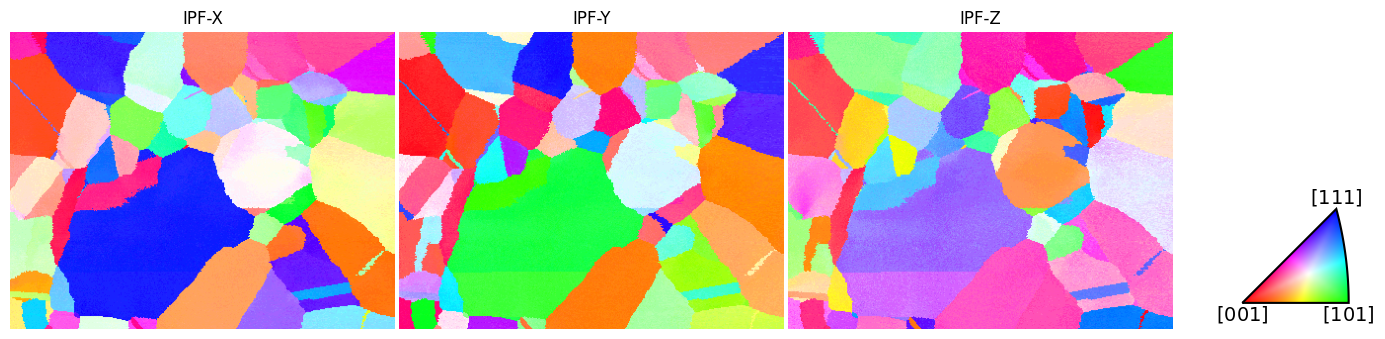

In [211]:
# Visualize EBSD data with inverse pole figure in the selected data region
from orix.vector import AxAngle, Vector3d
import matplotlib.pyplot as plt

ckey = plot.IPFColorKeyTSL(Oh)
directions = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
titles = ["X", "Y", "Z"]

## ALL DATA ##
fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ckey.direction = Vector3d(directions[i])
    # Invert because orix assumes lab2crystal when coloring orientations (bc inverse pole figure)
    ax.imshow(ckey.orientation2color(~ori_all))
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")

# Add color key
ax_ipfkey = fig.add_axes(
    [0.932, 0.37, 0.1, 0.1],  # (Left, bottom, width, height)
    projection="ipf",
    symmetry=ori.symmetry.laue,
)
ax_ipfkey.plot_ipf_color_key()
ax_ipfkey.set_title("")
fig.subplots_adjust(wspace=0.01)

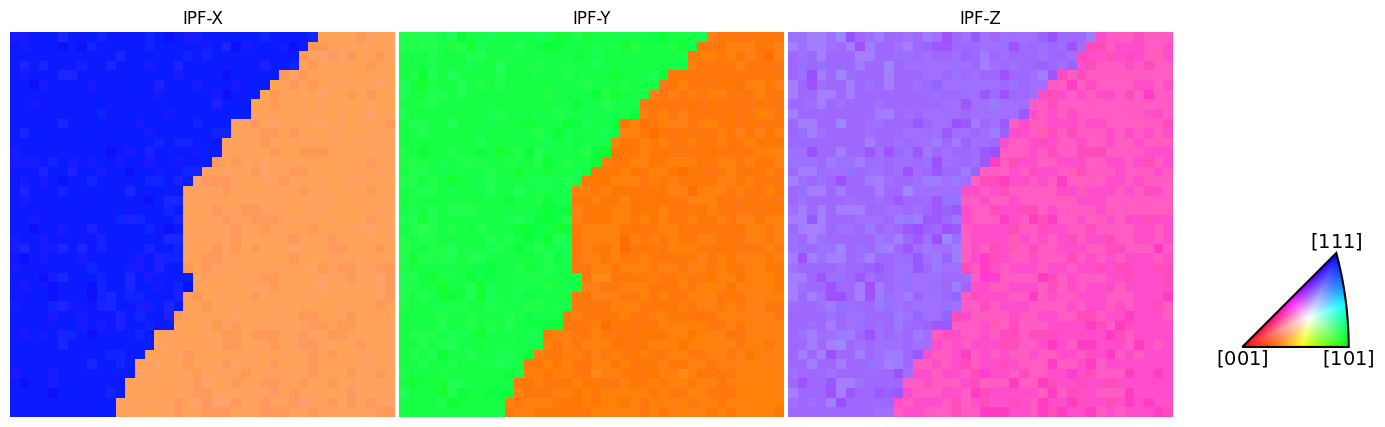

In [212]:
## ANALYZED DATA ##

fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ckey.direction = Vector3d(directions[i])
    # Invert because orix assumes lab2crystal when coloring orientations
    ax.imshow(ckey.orientation2color(~ori.reshape(shape)))
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")

# Add color key
ax_ipfkey = fig.add_axes(
    [0.932, 0.37, 0.1, 0.1],  # (Left, bottom, width, height)
    projection="ipf",
    symmetry=ori.symmetry.laue,
)
ax_ipfkey.plot_ipf_color_key()
ax_ipfkey.set_title("")
fig.subplots_adjust(wspace=0.01)

In [213]:
from orix.quaternion.symmetry import C1
# Remove symmetry by setting to point group 1 (identity operation)
ori_without_symmetry = Orientation(ori.data, symmetry=C1)

# Misorientations
mori1 = (ori_without_symmetry).outer(~ori_without_symmetry)

# Misorientation angles
D1 = mori1.angle
print(D1)

[[0.         0.         0.01745344 ... 1.2308559  1.21804675 1.21504319]
 [0.         0.         0.01745344 ... 1.2308559  1.21804675 1.21504319]
 [0.01745344 0.01745344 0.         ... 1.2300654  1.2173532  1.2141049 ]
 ...
 [1.2308559  1.2308559  1.2300654  ... 0.         0.01745332 0.02468255]
 [1.21804675 1.21804675 1.2173532  ... 0.01745332 0.         0.01745329]
 [1.21504319 1.21504319 1.2141049  ... 0.02468255 0.01745329 0.        ]]


In [214]:
# Use Sklearn PyPi library for unsupervised clustering (DBSCAN)
# Use pyplot to plot fundamental region
from sklearn.cluster import DBSCAN
dbscan_naive = DBSCAN(eps=0.1, min_samples=2, metric="precomputed").fit(D1)
print("Labels: ", np.unique(dbscan_naive.labels_))

Labels:  [0 1 2]


In [215]:
# Elements of symmetry groups are set transformations that leave an object invariant. \
# Symmetry groups are quaternion representations of point groups
# There are (naturally in 3D), 32 crystollographic point groups
# Our EBSD Nickel data exhibits Oh (m3m) cyrstallographic point group symmetry.
from orix.quaternion.symmetry import Oh

In [216]:
# Misorientations with symmetry
mori2 = (~ori).outer(ori)
mori2.symmetry = Oh
mori2 = mori2.map_into_symmetry_reduced_zone()
D2 = mori2.angle

In [217]:
dbscan = DBSCAN(
    eps=np.deg2rad(17), min_samples=2, metric="precomputed"
).fit(D2.astype(np.float32))
print("Labels:", np.unique(dbscan.labels_))

Labels: [0 1]


In [218]:
# Colorisation & Animation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb
import matplotlib.animation as animation
import matplotlib.pyplot as plt

color_names = [to_rgb(f"C{i}") for i in range(6)]  # ['C0', 'C1', ...]

colors_naive = label2rgb(
    dbscan_naive.labels_, colors=color_names, bg_label=-1
)
colors = label2rgb(dbscan.labels_, colors=color_names, bg_label=-1)

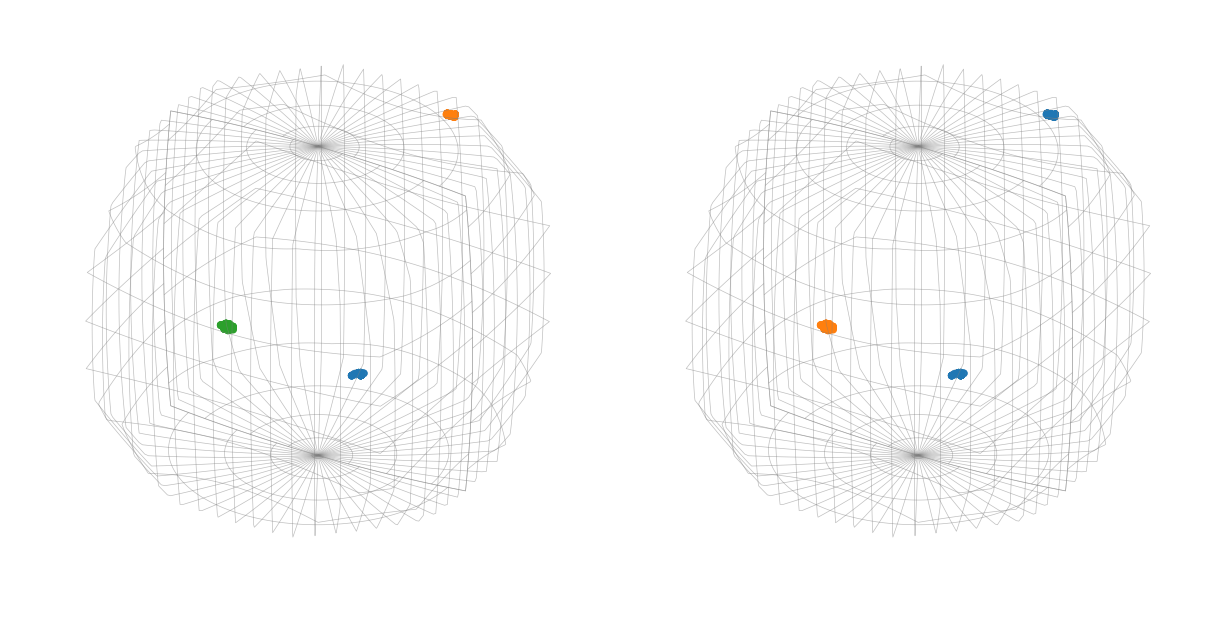

In [219]:
# Set symmetry to "trick" the scatter plot to use the Oh fundamental zone
ori_without_symmetry.symmetry = ori.symmetry

# Create figure with a height/width ratio of 1/2
fig = plt.figure(figsize=(12, 6))

# Add the fundamental zones with clusters to the existing figure
ori_without_symmetry.scatter(figure=fig, position=(1, 2, 1), c=colors_naive)
ori.scatter(figure=fig, position=122, c=colors)


In [220]:
#### SLERP setup code ####
## Quaternion class handles quaternion multiplication, as well as spherical linear interpolation (slerp) ##
## quat_upsampling function: performs bilinear slerp interpolation of 2D array of quaternions ##

import numpy as np
import math

inv_sqrt_2 = 1 / np.sqrt(2.0)
half = 0.5

fcc_syms = np.array([
                [1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1],
                [inv_sqrt_2, inv_sqrt_2, 0, 0 ],
                [inv_sqrt_2, 0, inv_sqrt_2, 0],
                [inv_sqrt_2, 0, 0, inv_sqrt_2],
                [inv_sqrt_2, -inv_sqrt_2, 0, 0],
                [inv_sqrt_2, 0, -inv_sqrt_2, 0],
                [inv_sqrt_2, 0, 0, -inv_sqrt_2],
                [0, inv_sqrt_2, inv_sqrt_2, 0],
                [0, inv_sqrt_2, 0, inv_sqrt_2],
                [0, 0, inv_sqrt_2, inv_sqrt_2],
                [0, inv_sqrt_2, -inv_sqrt_2, 0],
                [0, 0, inv_sqrt_2, -inv_sqrt_2],
                [0, inv_sqrt_2, 0, -inv_sqrt_2],
                [half, half, half, half],
                [half, -half, -half, half],
                [half, -half, half, -half],
                [half, half, -half, -half],
                [half, half, half, -half],
                [half, half, -half, half],
                [half, -half, half, half],
                [half, -half, -half, -half]
            ], dtype=np.float32)

class Quat:
    def __init__(self, q):
        self.q = q

    def copy(self):
        return Quat(self.q.copy())

    def __getitem__(self, idx):
        return self.q[idx]

    def __setitem__(self, val, idx=None):
        if (idx == None):
            set_array(self, val)
        else:
            self.q[idx] = val

    def set_array(self, array):
        self.q = array

    def __pow__(self, t):
        new_q_array = np.zeros(4)
        mag = math.sqrt(self.q[0]**2 + self.q[1]**2 + self.q[2]**2 + self.q[3]**2)
        phi = math.acos(self.q[0] / mag)
        v = self.q[1:4] # quaternion versor
        v_mag = math.sqrt(v[0]**2 + v[1]**2 + v[2]**2)
        if v_mag != 0:
            normal = v / v_mag
        else:
            # import pdb; pdb.set_trace()
            normal = v
        new_q_array[0] = mag**t * math.cos(t*phi)
        new_q_array[1:4] = (mag**t * math.sin(t*phi)) * v
        
        return(Quat(new_q_array))

    def __neg__(self):
        self.q = -self.q

    def __add__(self, q2): # addition overload
        self.q = self.q + q2

    def __mul__(self, q2): # multiplication overload (Hamilton product)
        if isinstance(q2, Quat): # perform hamilton product if q2 is a quaternion
            q_n = np.zeros(4)
            q_n[0] = self.q[0]*q2.q[0] - self.q[1]*q2.q[1] - self.q[2]*q2.q[2] - self.q[3]*q2.q[3]
            q_n[1] = self.q[0]*q2.q[1] + self.q[1]*q2.q[0] + self.q[2]*q2.q[3] - self.q[3]*q2.q[2]
            q_n[2] = self.q[0]*q2.q[2] - self.q[1]*q2.q[3] + self.q[2]*q2.q[0] + self.q[3]*q2.q[1]
            q_n[3] = self.q[0]*q2.q[3] + self.q[1]*q2.q[2] - self.q[2]*q2.q[1] + self.q[3]*q2.q[0]
            return(Quat(q_n))
        else: # if q2 is a scalar:
            return(Quat(q2 * self.q))

    def inverse(self):
        mag = self.q[0]**2 + self.q[1]**2 + self.q[2]**2 + self.q[3]**2
        return(Quat(mag * np.array([self.q[0], -self.q[1], -self.q[2], -self.q[3]])))


def permute_X(X):
    restore_shape = X.shape
    X_flat = X.flatten()
    X_length = X_flat.shape[0]
    for index in range(int(X_length / 4)):

        k = 4 * index
        temp = X_flat[k + 1]
        X_flat[k + 1] = X_flat[k]
        X_flat[k] = X_flat[k + 3]
        X_flat[k + 3] = X_flat[k + 2]
        X_flat[k + 2] = temp

    X = X_flat.reshape(restore_shape)
    return(X)

# spherical interpolation, used for quaternions
 # slerp = (q1*q0^-1)^t * q0 #
def slerp(q0, q1, t, sym_reduce=False):
    q0 = q0.copy()
    q1 = q1.copy()
    
    if sym_reduce:
        q1 = symmetry_reduce(q0, q1, fcc_syms)  # Make q1 closest sym equivalent

    dot = np.dot(q0.q, q1.q)  # Assuming .q is the 4D vector (scalar-first or last)
    
    # Ensure short arc
    if dot < 0:
        q1 = -q1  # Negate to take shortest path
    
    # SLERP: q_interp = q0 * (q0⁻¹ * q1)^t
    delta = q0.inverse() * q1
    return (q0 * (delta ** t))

def symmetry_reduce(q0, q1, sym_group):
    # Relative rotation (misorientation)
    A = q0.inverse() * q1
    # Try all symmetry-equivalent versions
    A_syms = [Quat(sym_op) * A for sym_op in sym_group]
    # Choose the one with the smallest angle (max |scalar part|)
    A_min = max(A_syms, key=lambda q: abs(q.q[0]))  # Assuming scalar-first
    # Recover symmetrically closest q1
    q1_min = q0 * A_min
    return q1_min
    

def quat_upsampling(X, scale=4, symmetry_aware=False): # X is low-resolution numpy-array
        # import pdb; pdb.set_trace()
        # X = permute_X(X) # convert from quaternion scalar_last convention to scalar_first.
        X_rows = X.shape[0]; X_cols = X.shape[1]
        interp_factor = scale
        X_SR = np.zeros([scale * X_rows, scale * X_cols, 4], dtype=np.float32) # Super-resolved numpy-array

        for i in range(scale * X_rows):

            for j in range(scale * X_cols):

                x1 = math.floor(j/scale)
                x2 = math.floor(j/scale) + 1
                y1 = math.floor(i/scale)
                y2 = math.floor(i/scale) + 1

                # Check algorithm didn't exit bounds of original quat matrix
                if (y2 == X.shape[0]):
                    y2 = X.shape[0] - 1
                if (x2 == X.shape[1]):
                    x2 = X.shape[1] - 1

                q1 = Quat(X[y2][x1]) # quats from LR cell
                q2 = Quat(X[y2][x2])
                q3 = Quat(X[y1][x1])
                q4 = Quat(X[y1][x2])
                t_x = (j % scale) / scale # find mod, and normalize to obtain interpolation parameter, 't'.
                q_interp_x1 = slerp(q1, q2, t_x, symmetry_aware)
                q_interp_x2 = slerp(q3, q4, t_x, symmetry_aware)
                # y-interpolation:
                t_y = (i % scale) / scale
                X_SR[i][j] = slerp(q_interp_x1, q_interp_x2, t_y, symmetry_aware).q # slerp returns Quat object, so get its numpy array.
                
        return(X_SR)

In [221]:
data_slerped = quat_upsampling(data)
ori_slerp = Orientation(data_slerped)

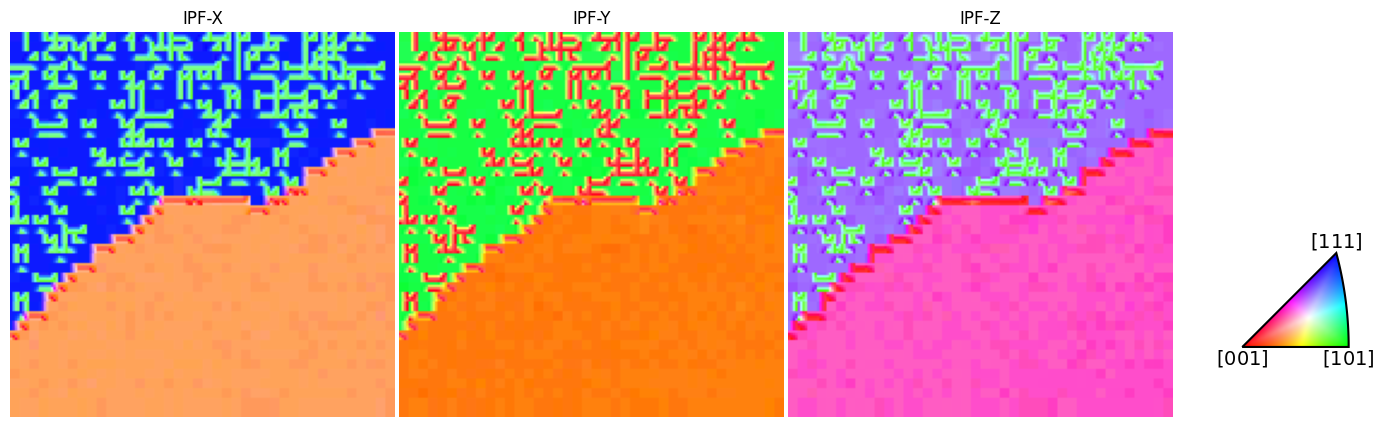

In [222]:
## INTERPOLATED (NAIVE SLERP) DATA ##

fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ckey.direction = Vector3d(directions[i])
    # Invert because orix assumes lab2crystal when coloring orientations
    ax.imshow(ckey.orientation2color(~ori_slerp))
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")

# Add color key
ax_ipfkey = fig.add_axes(
    [0.932, 0.37, 0.1, 0.1],  # (Left, bottom, width, height)
    projection="ipf",
    symmetry=ori.symmetry.laue,
)
ax_ipfkey.plot_ipf_color_key()
ax_ipfkey.set_title("")
fig.subplots_adjust(wspace=0.01)

Orientation (5, 5) 1
[[[-0.3589  0.2864 -0.1679  0.8724]
  [-0.3589  0.2864 -0.1679  0.8724]
  [-0.3595  0.2818 -0.1519  0.8765]
  [ 0.3574  0.3162  0.0842  0.8748]
  [ 0.3574  0.3162  0.0842  0.8748]]

 [[ 0.3601  0.313   0.0919  0.874 ]
  [ 0.3596  0.3018  0.0923  0.8781]
  [ 0.3574  0.3162  0.0842  0.8748]
  [ 0.3574  0.3162  0.0842  0.8748]
  [ 0.3596  0.3018  0.0923  0.8781]]

 [[ 0.3574  0.3162  0.0842  0.8748]
  [ 0.3601  0.313   0.0919  0.874 ]
  [-0.3589  0.2864 -0.1679  0.8724]
  [ 0.3596  0.3018  0.0923  0.8781]
  [-0.3589  0.2864 -0.1679  0.8724]]

 [[ 0.3574  0.3162  0.0842  0.8748]
  [-0.3595  0.2818 -0.1519  0.8765]
  [ 0.3601  0.313   0.0919  0.874 ]
  [ 0.3601  0.313   0.0919  0.874 ]
  [ 0.3574  0.3162  0.0842  0.8748]]

 [[-0.3589  0.2864 -0.1679  0.8724]
  [-0.3602  0.2764 -0.1624  0.8761]
  [ 0.3601  0.313   0.0919  0.874 ]
  [ 0.3574  0.3162  0.0842  0.8748]
  [ 0.3574  0.3162  0.0842  0.8748]]]


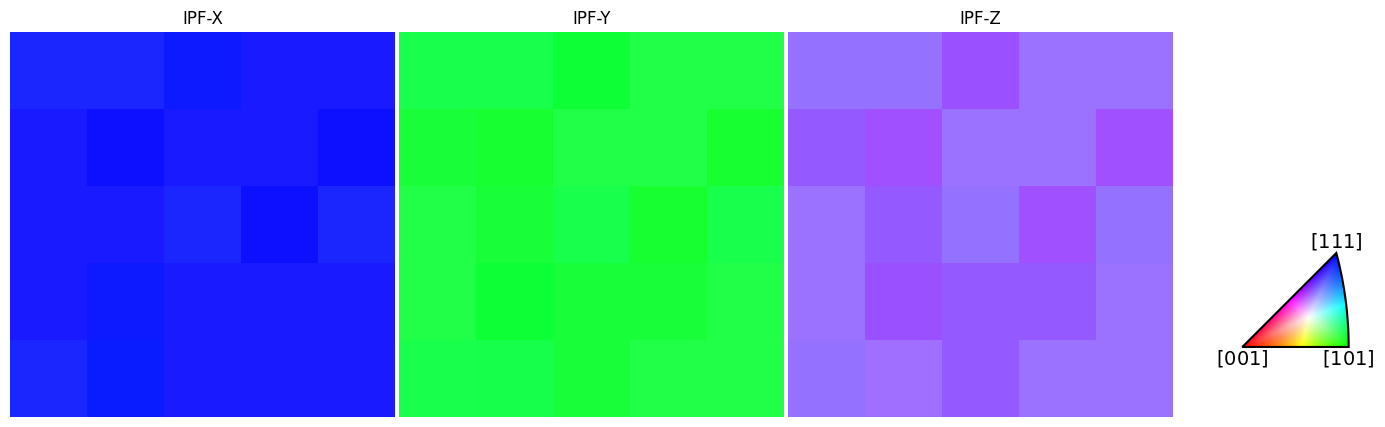

In [223]:
# Single out a single slerp interpolation causing a symmetry artifact
data_zoom = all_data[200:200 + 4 +1, 156:156+4+1]
ori_zoom = Orientation(data_zoom)

print(ori_zoom)

fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ckey.direction = Vector3d(directions[i])
    # Invert because orix assumes lab2crystal when coloring orientations
    ax.imshow(ckey.orientation2color(~ori_zoom))
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")

# Add color key
ax_ipfkey = fig.add_axes(
    [0.932, 0.37, 0.1, 0.1],  # (Left, bottom, width, height)
    projection="ipf",
    symmetry=ori.symmetry.laue,
)
ax_ipfkey.plot_ipf_color_key()
ax_ipfkey.set_title("")
fig.subplots_adjust(wspace=0.01)

## Let's add the position of each pole in the pole figure, so we can get a sense of its symmetry zone.



In [224]:
# Misorientations without symmetry
ori_zoom_no_sym = Orientation(data_zoom, symmetry=C1)
ori_zoom_no_sym = ori_zoom_no_sym.flatten()
mori = (~ori_zoom_no_sym).outer(ori_zoom_no_sym)
D1 = mori.angle

# Misorientations with symmetry
ori_zoom = Orientation(data_zoom, symmetry=Oh)
ori_zoom = ori_zoom.flatten()
mori = (~ori_zoom).outer(ori_zoom)
mori.symmetry = Oh
mori = mori.map_into_symmetry_reduced_zone()
D2 = mori.angle


# ## dbscan epsilon --> The maximum distance for two samples to be in the same neighborhood
dbscan1 = DBSCAN(
    eps=0.1, min_samples=2, metric="precomputed"
).fit(D1.astype(np.float32))
print("Labels:", np.unique(dbscan1.labels_))

label = dbscan1.labels_

dbscan2 = DBSCAN(
    eps=0.1, min_samples=2, metric="precomputed"
).fit(D2.astype(np.float32))
print("Labels:", np.unique(dbscan2.labels_))

Labels: [0 1]
Labels: [0]


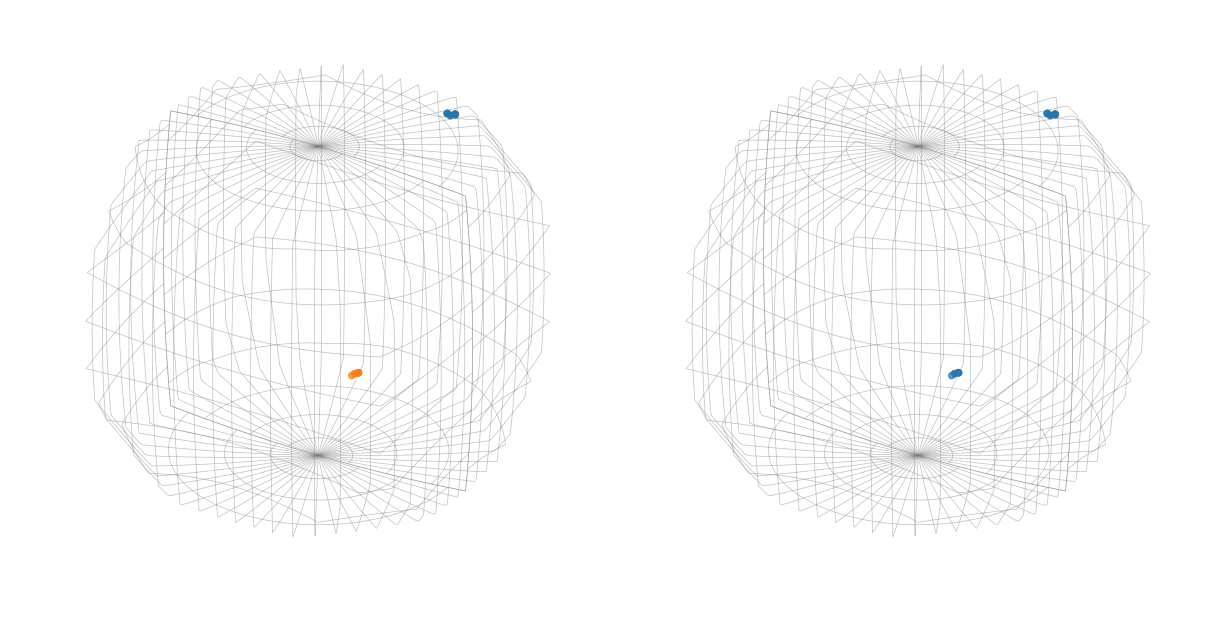

In [225]:
color_names = [to_rgb(f"C{i}") for i in range(6)]  # ['C0', 'C1', ...]

colors_no_sym = label2rgb(dbscan1.labels_, colors=color_names, bg_label=-1) 

colors_sym = label2rgb(dbscan2.labels_, colors=color_names, bg_label=-1)

# Set symmetry to "trick" the scatter plot to use the Oh fundamental zone
ori_zoom_no_sym.symmetry = ori_zoom.symmetry

# Create figure with a height/width ratio of 1/2
fig = plt.figure(figsize=(12, 6))

# Add the fundamental zones with clusters to the existing figure
ori_zoom_no_sym.scatter(figure=fig, position=(1, 2, 1), c=colors_no_sym)
ori_zoom.scatter(figure=fig, position=122, c=colors_sym)

In [226]:
# convert to scalar first for slerp
print(data_zoom)
# data_zoom = np.roll(data_zoom, shift=1, axis=-1)
print(data_zoom)

data_zoom_slerped = quat_upsampling(data_zoom)
print(data_zoom.shape)

# # # convert back to scalar last after slerp
# data_zoom_slerped = np.roll(data_zoom_slerped, shift=1, axis=-1)

print(data_zoom_slerped.shape)
ori_zoom_slerped = Orientation(data_zoom_slerped)

[[[-0.3588512   0.28643006 -0.16787833  0.87235343]
  [-0.3588512   0.28643006 -0.16787833  0.87235343]
  [-0.35954833  0.28183368 -0.15192226  0.87647843]
  [ 0.3573708   0.31617492  0.08423099  0.87477124]
  [ 0.3573708   0.31617492  0.08423099  0.87477124]]

 [[ 0.3601163   0.3130443   0.09186152  0.87400293]
  [ 0.35963607  0.3017705   0.09229299  0.87811065]
  [ 0.3573708   0.31617492  0.08423099  0.87477124]
  [ 0.3573708   0.31617492  0.08423099  0.87477124]
  [ 0.35963607  0.3017705   0.09229299  0.87811065]]

 [[ 0.3573708   0.31617492  0.08423099  0.87477124]
  [ 0.3601163   0.3130443   0.09186152  0.87400293]
  [-0.3588512   0.28643006 -0.16787833  0.87235343]
  [ 0.35963607  0.3017705   0.09229299  0.87811065]
  [-0.3588512   0.28643006 -0.16787833  0.87235343]]

 [[ 0.3573708   0.31617492  0.08423099  0.87477124]
  [-0.35954833  0.28183368 -0.15192226  0.87647843]
  [ 0.3601163   0.3130443   0.09186152  0.87400293]
  [ 0.3601163   0.3130443   0.09186152  0.87400293]
  [ 0.

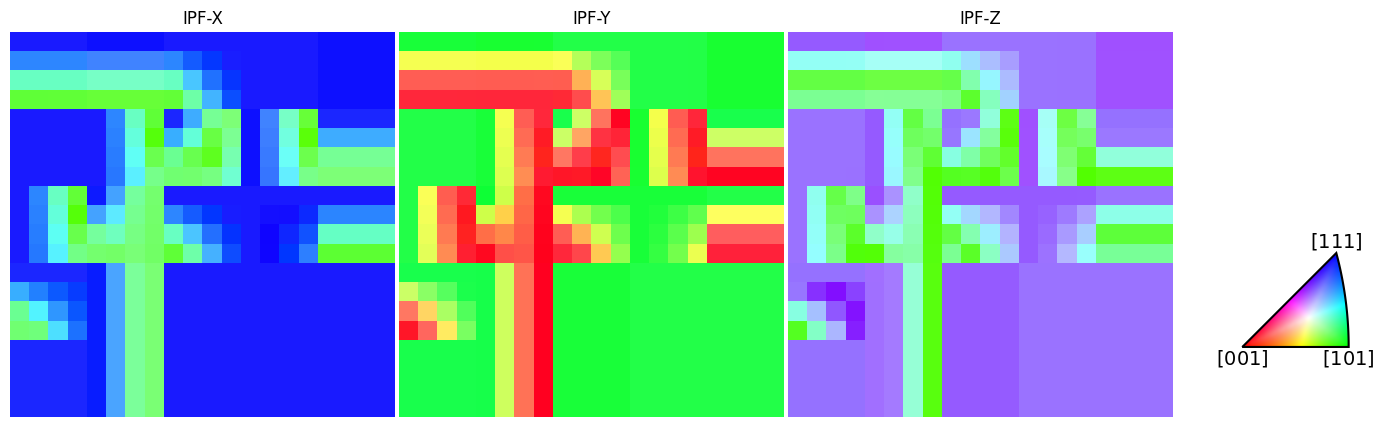

In [227]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ckey.direction = Vector3d(directions[i])
    # Invert because orix assumes lab2crystal when coloring orientations
    ax.imshow(ckey.orientation2color(~ori_zoom_slerped))
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")

# Add color key
ax_ipfkey = fig.add_axes(
    [0.932, 0.37, 0.1, 0.1],  # (Left, bottom, width, height)
    projection="ipf",
    symmetry=ori.symmetry.laue,
)
ax_ipfkey.plot_ipf_color_key()
ax_ipfkey.set_title("")
fig.subplots_adjust(wspace=0.01)

In [228]:
# Misorientations without symmetry
ori_zoom_slerp_no_sym = Orientation(data_zoom_slerped, symmetry=C1)
ori_zoom_slerp_no_sym = ori_zoom_slerp_no_sym.flatten()
mori = (~ori_zoom_slerp_no_sym).outer(ori_zoom_slerp_no_sym)
D3 = mori.angle
print(D3.shape)

# Misorientations with symmetry
ori_zoom_slerp = Orientation(data_zoom_slerped, symmetry=Oh)
ori_zoom_slerp = ori_zoom_slerp.flatten()
mori = (~ori_zoom_slerp).outer(ori_zoom_slerp)
mori.symmetry = Oh
mori = mori.map_into_symmetry_reduced_zone()
D4 = mori.angle
print(D4.shape)

(400, 400)
(400, 400)


In [229]:
# ## dbscan epsilon --> The maximum distance between two samples for one to be considered as in the neighborhood of the other
dbscan3 = DBSCAN(
    eps=0.5, min_samples=1, metric="precomputed"
).fit(D3.astype(np.float32))
print("Labels:", np.unique(dbscan3.labels_))

dbscan4 = DBSCAN(
    eps=0.5, min_samples=1, metric="precomputed"
).fit(D4.astype(np.float32))
print("Labels:", np.unique(dbscan4.labels_))

Labels: [0]
Labels: [0]


(400, 3)
(400, 3)


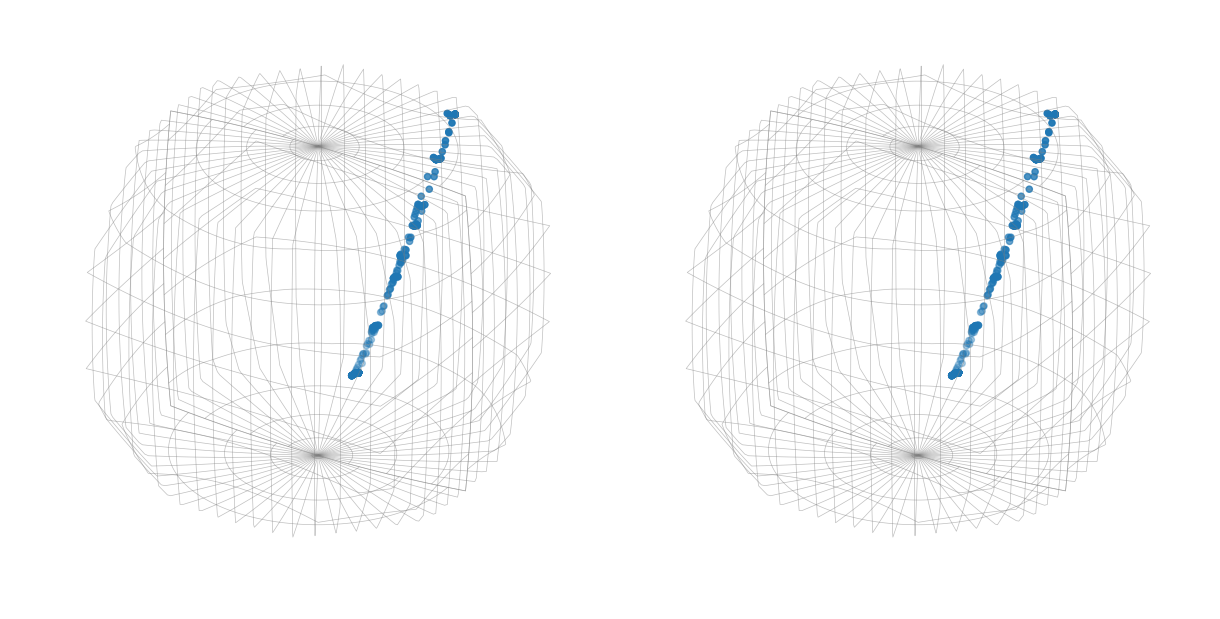

In [230]:
color_names = [to_rgb(f"C{i}") for i in range(6)]  # ['C0', 'C1', ...]

colors_naive = label2rgb(dbscan3.labels_, colors=color_names, bg_label=-1)
colors = label2rgb(dbscan4.labels_, colors=color_names, bg_label=-1)

print(colors_naive.shape)
print(colors.shape)

# Set symmetry to "trick" the scatter plot to use the Oh fundamental zone
ori_zoom_slerp_no_sym.symmetry = ori_zoom_slerp.symmetry

# Create figure with a height/width ratio of 1/2
fig = plt.figure(figsize=(12, 6))

# Add the fundamental zones with clusters to the existing figure
ori_zoom_slerp_no_sym.scatter(figure=fig, position=(1, 2, 1), c=colors_naive)
ori_zoom_slerp.scatter(figure=fig, position=122, c=colors)

In [231]:
## Symmetry-aware bilinear slerp on data_zoom
slerped_symm_aware = quat_upsampling(data_zoom, symmetry_aware=True)
ori_zoom_slerp = Orientation(slerped_symm_aware)

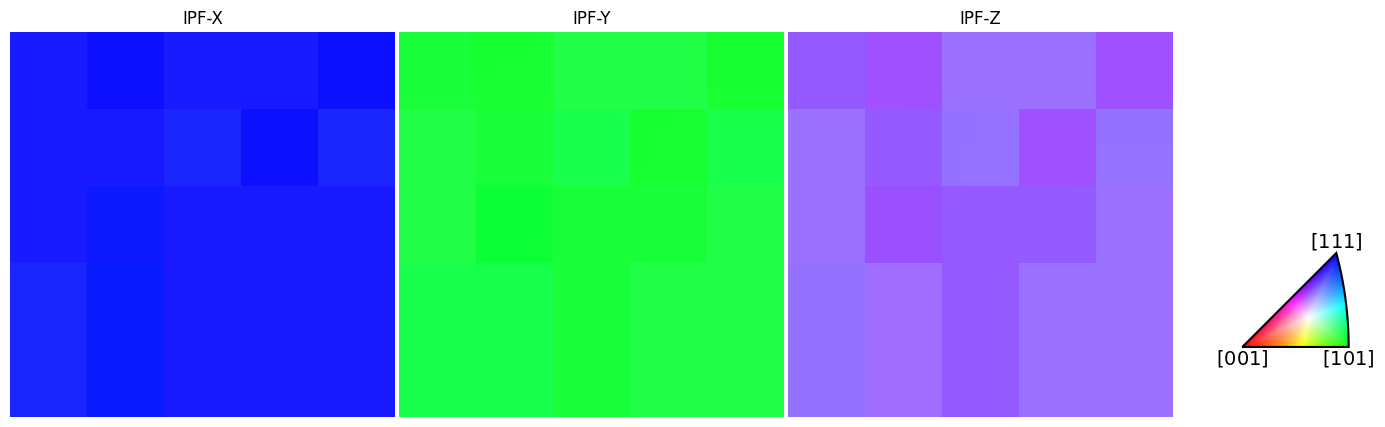

In [232]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 10))
for i, ax in enumerate(axes):
    ckey.direction = Vector3d(directions[i])
    # Invert because orix assumes lab2crystal when coloring orientations
    ax.imshow(ckey.orientation2color(~ori_zoom_slerp))
    ax.set_title(f"IPF-{titles[i]}")
    ax.axis("off")

# Add color key
ax_ipfkey = fig.add_axes(
    [0.932, 0.37, 0.1, 0.1],  # (Left, bottom, width, height)
    projection="ipf",
    symmetry=ori.symmetry.laue,
)
ax_ipfkey.plot_ipf_color_key()
ax_ipfkey.set_title("")
fig.subplots_adjust(wspace=0.01)